****
# Sentiment Analysis  For Adidas Shoes
****

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. Valence Aware Dictionary and sEntiment Reasoner (VADER) - Bag of words approach
2. Textblob
3. SentiWord Net

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from textblob import TextBlob
plt.style.use('ggplot')
from rid_utils import show_category, show_distribution

import warnings
warnings.filterwarnings("ignore")

In [2]:
path1 = "C:/Users/DELL/Project/FreeWorks/Sentiment Analysis for Adidas and Twitter/Sentiment Analysis App/adidas_data_15-09-2023.csv"
path2 = "C:/Users/DELL/Project/FreeWorks/Sentiment Analysis for Adidas and Twitter/Sentiment Analysis App/adidas_extracted_shoe_data.csv"

df = pd.read_csv(path2, index_col=[0])

In [3]:
rating = pd.read_csv("shoes_rating-16_02_2023.csv")
rating.shape

(9, 2)

In [4]:
rating.rename(columns={"Product Name": "Title"}, inplace=True)

In [5]:
rating

,Title,Average Rating
0,Samba OG Shoes,4.8
1,Campus 00s Shoes,4.7
2,Gazelle Indoor Shoes,4.6
3,Samba ADV Shoes,4.5
4,NMD_R1 Shoes,4.4
5,Samba Classic,4.3
6,NMD_S1 Shoes,4.2
7,Nizza Platform Shoes,4.1
8,Adifom Stan Smith Mule Shoes,4.0


In [6]:
df.head()

,Title,Price,ColoursAvailable,ReviewTopic,Reviews,ReviewInfo
0,Samba OG Shoes,100,6,Nice quality shoes,They match practically with any outfit that I...,"abdubs35 | September 13, 2023"
1,Samba OG Shoes,100,6,Nice shoes,"Very nice shoes , just not as green as the pic...","THEMAN | September 13, 2023 | Incentivized Review"
2,Samba OG Shoes,100,6,Buy the shoes!,"Bang on trend, comfy and cool. Would recommend...","Huggsy | September 12, 2023 | Verified Purchas..."
3,Samba OG Shoes,100,6,ALL GOODS SOLID! WORTH THE PRICE!,THAT WAS DOPE! medyo mahaba lng ng very little...,"TOYOTABOY | September 12, 2023"
4,Samba OG Shoes,100,6,Never out of style,Love how light on your feet they are and comfo...,"SangeBo | September 12, 2023"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1708 entries, 0 to 131
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Title             1708 non-null   object
 1   Price             1708 non-null   int64 
 2   ColoursAvailable  1708 non-null   int64 
 3   ReviewTopic       1706 non-null   object
 4   Reviews           1707 non-null   object
 5   ReviewInfo        1640 non-null   object
dtypes: int64(2), object(4)
memory usage: 93.4+ KB


In [8]:
df.columns

Index(['Title', 'Price', 'ColoursAvailable', 'ReviewTopic', 'Reviews',
       'ReviewInfo'],
      dtype='object')

In [9]:
df.iloc[1009:]["Reviews"]

176    Color way is dope and perfect fit will. Buy mo...
177    I've bought at least 4 pair of these! Super co...
178    Not comfortable at all. Very hard to put on. T...
179    The shoes are super uncomfortable, it hurts my...
180    Comfortable shoes. I own them in every color a...
                             ...                        
127    They are good to wear if you are a nurse and w...
128    Goes well with what I had on had me feeling my...
129    Just love my new adidas gear, never fails me t...
130    Perfect color! Nice, comfortable shoe. I wasn’...
131    arrived in time for a trip i was taking. broke...
Name: Reviews, Length: 699, dtype: object

In [10]:
def wrangle_adidas_data(data):
    
    data = data.copy()
    data.ReviewInfo.fillna("No Info", inplace=True)
   
    users = []
    dates = []
    verifys = []
    reviews= []

    for dat in data["ReviewInfo"]:
        if dat is not "No Info":
            #iterate through on several conditions
            if dat is not None:
                dat_split = dat.split("|")
                if len(dat_split) >= 4:
                    users.append(dat_split[0])
                    dates.append(dat_split[1])
                    verifys.append(True)
                    reviews.append(True)
                elif len(dat_split) == 3:
                    users.append(dat_split[0])
                    dates.append(dat_split[1])
                    if dat_split[2] == ' Verified Purchaser ':
                        verifys.append(True)
                        reviews.append(False)
                    else:
                        verifys.append(False)
                        reviews.append(True)
                else:
                    users.append(dat_split[0])
                    dates.append(dat_split[1])
                    verifys.append(False)
                    reviews.append(False)

            else:
                users.append(None)
                dates.append(None)
                verifys.append(False)
                reviews.append(False)
        else:
            users.append(None)
            dates.append(None)
            verifys.append(False)
            reviews.append(False)
            

    data["UserID"] = users 
    data["Date"] = dates
    data["VerifiedPurchaser"] = verifys
    data["IncentivizedReview"] = reviews

    data.drop(columns="ReviewInfo", inplace=True)
    data["Price"].astype(int)
    data["ColoursAvailable"].astype(int)
    data.UserID.fillna("Unknown", inplace=True)
    data.Reviews.fillna("No Topic", inplace=True)
    
    return data

df = wrangle_adidas_data(df)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1708 entries, 0 to 131
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Title               1708 non-null   object
 1   Price               1708 non-null   int64 
 2   ColoursAvailable    1708 non-null   int64 
 3   ReviewTopic         1706 non-null   object
 4   Reviews             1708 non-null   object
 5   UserID              1708 non-null   object
 6   Date                1640 non-null   object
 7   VerifiedPurchaser   1708 non-null   bool  
 8   IncentivizedReview  1708 non-null   bool  
dtypes: bool(2), int64(2), object(5)
memory usage: 110.1+ KB


In [12]:
df["ID"] = range(1, len(df)+1)
df

,Title,Price,ColoursAvailable,ReviewTopic,Reviews,UserID,Date,VerifiedPurchaser,IncentivizedReview,ID
0,Samba OG Shoes,100,6,Nice quality shoes,They match practically with any outfit that I...,abdubs35,"September 13, 2023",False,False,1
1,Samba OG Shoes,100,6,Nice shoes,"Very nice shoes , just not as green as the pic...",THEMAN,"September 13, 2023",False,True,2
2,Samba OG Shoes,100,6,Buy the shoes!,"Bang on trend, comfy and cool. Would recommend...",Huggsy,"September 12, 2023",True,True,3
3,Samba OG Shoes,100,6,ALL GOODS SOLID! WORTH THE PRICE!,THAT WAS DOPE! medyo mahaba lng ng very little...,TOYOTABOY,"September 12, 2023",False,False,4
4,Samba OG Shoes,100,6,Never out of style,Love how light on your feet they are and comfo...,SangeBo,"September 12, 2023",False,False,5
...,...,...,...,...,...,...,...,...,...,...
127,Adifom Stan Smith Mule Shoes,70,4,I love these they are so comfortable and stylish.,They are good to wear if you are a nurse and w...,Unknown,None,False,False,1704
128,Adifom Stan Smith Mule Shoes,70,4,Very Very Comfortable love the color,Goes well with what I had on had me feeling my...,Unknown,None,False,False,1705
129,Adifom Stan Smith Mule Shoes,70,4,You feel like your walking on air.,"Just love my new adidas gear, never fails me t...",Unknown,None,False,False,1706
130,Adifom Stan Smith Mule Shoes,70,4,I absolutely love them,"Perfect color! Nice, comfortable shoe. I wasn’...",Unknown,None,False,False,1707


In [13]:
df = df.merge(rating, how="left")
df.head()

,Title,Price,ColoursAvailable,ReviewTopic,Reviews,UserID,Date,VerifiedPurchaser,IncentivizedReview,ID,Average Rating
0,Samba OG Shoes,100,6,Nice quality shoes,They match practically with any outfit that I...,abdubs35,"September 13, 2023",False,False,1,4.8
1,Samba OG Shoes,100,6,Nice shoes,"Very nice shoes , just not as green as the pic...",THEMAN,"September 13, 2023",False,True,2,4.8
2,Samba OG Shoes,100,6,Buy the shoes!,"Bang on trend, comfy and cool. Would recommend...",Huggsy,"September 12, 2023",True,True,3,4.8
3,Samba OG Shoes,100,6,ALL GOODS SOLID! WORTH THE PRICE!,THAT WAS DOPE! medyo mahaba lng ng very little...,TOYOTABOY,"September 12, 2023",False,False,4,4.8
4,Samba OG Shoes,100,6,Never out of style,Love how light on your feet they are and comfo...,SangeBo,"September 12, 2023",False,False,5,4.8


In [14]:
df.to_csv("adidas_web_review.to_csv")

****
# Exploratory Data Analysis
*****

In [15]:
df.VerifiedPurchaser.value_counts(normalize=True)

False    0.723068
True     0.276932
Name: VerifiedPurchaser, dtype: float64

In [16]:
df.IncentivizedReview.value_counts(normalize=True)

False    0.605386
True     0.394614
Name: IncentivizedReview, dtype: float64

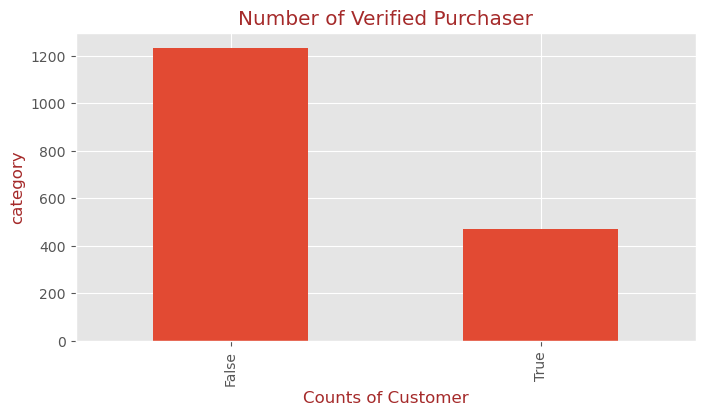

In [17]:
fig, ax = plt.subplots(figsize=(8,4))
df.VerifiedPurchaser.value_counts().plot(kind="bar")
plt.title("Number of Verified Purchaser", color="brown")
plt.xlabel("Counts of Customer", color="brown")
plt.ylabel("category", color="brown")
plt.show()

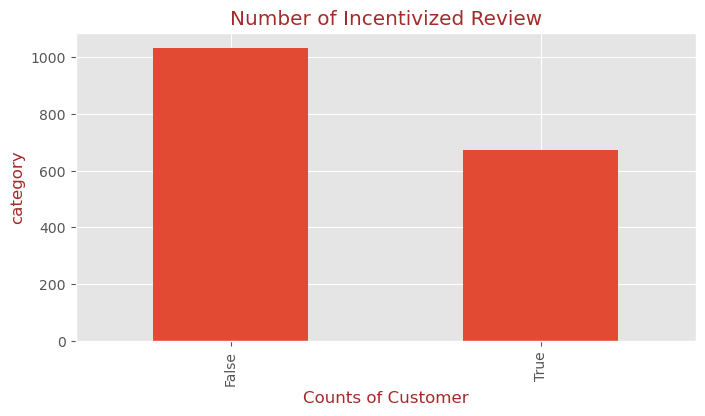

In [18]:
fig, ax = plt.subplots(figsize=(8,4))
df.IncentivizedReview.value_counts().plot(kind="bar")
plt.title("Number of Incentivized Review", color="brown")
plt.xlabel("Counts of Customer", color="brown")
plt.ylabel("category", color="brown")
plt.show()

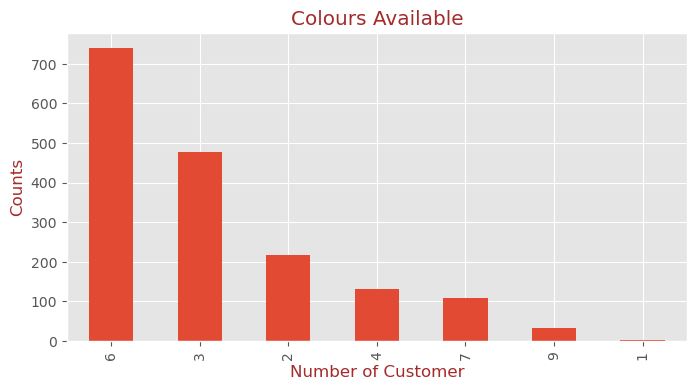

In [19]:
fig, ax = plt.subplots(figsize=(8,4))
df.ColoursAvailable.value_counts().plot(kind="bar")
plt.title("Colours Available", color="brown")
plt.xlabel("Number of Customer", color="brown")
plt.ylabel("Counts", color="brown")
plt.show()

The statistical values are as follows:
 Minimum value:70.00
 Maximum value: 150.00
 Mode: 100.00 
 Mean: 103.14 
 Standard Deviation: 24.14 
 Variance: 4.91 
 Median: 100.00


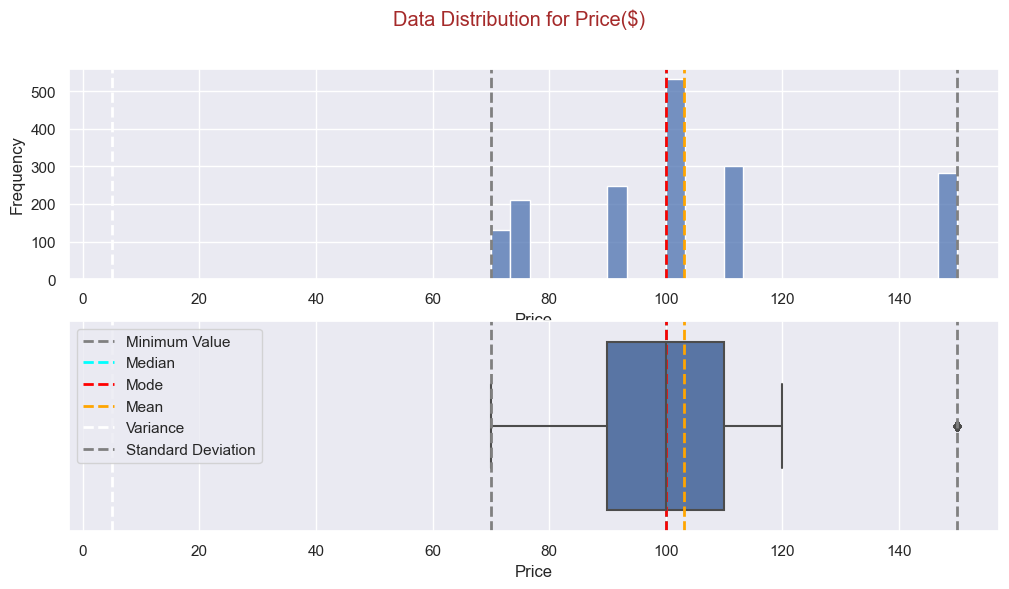

In [20]:
show_distribution(df["Price"], "Price($)")

In [21]:
#nltk.download('punkt')

In [22]:
example = df.iloc[4]['Reviews']
print(example)

Love how light on your feet they are and comfortable. I’ve been a Samba wearer for years and they never get old.


In [23]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['Love',
 'how',
 'light',
 'on',
 'your',
 'feet',
 'they',
 'are',
 'and',
 'comfortable']

In [24]:
#nltk.download('averaged_perceptron_tagger')
tagged = nltk.pos_tag(tokens)
tagged

[('Love', 'VB'),
 ('how', 'WRB'),
 ('light', 'JJ'),
 ('on', 'IN'),
 ('your', 'PRP$'),
 ('feet', 'NNS'),
 ('they', 'PRP'),
 ('are', 'VBP'),
 ('and', 'CC'),
 ('comfortable', 'JJ'),
 ('.', '.'),
 ('I', 'PRP'),
 ('’', 'VBP'),
 ('ve', 'RB'),
 ('been', 'VBN'),
 ('a', 'DT'),
 ('Samba', 'NNP'),
 ('wearer', 'NN'),
 ('for', 'IN'),
 ('years', 'NNS'),
 ('and', 'CC'),
 ('they', 'PRP'),
 ('never', 'RB'),
 ('get', 'VBP'),
 ('old', 'JJ'),
 ('.', '.')]

In [25]:
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  Love/VB
  how/WRB
  light/JJ
  on/IN
  your/PRP$
  feet/NNS
  they/PRP
  are/VBP
  and/CC
  comfortable/JJ
  ./.
  I/PRP
  ’/VBP
  ve/RB
  been/VBN
  a/DT
  (GPE Samba/NNP)
  wearer/NN
  for/IN
  years/NNS
  and/CC
  they/PRP
  never/RB
  get/VBP
  old/JJ
  ./.)


****
# VADER Sentiment 
****

In [26]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [27]:
sia.polarity_scores(df.iloc[1001]['Reviews'])

{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'compound': 0.5563}

In [28]:
df["Reviews"]

0       They match practically with  any outfit that I...
1       Very nice shoes , just not as green as the pic...
2       Bang on trend, comfy and cool. Would recommend...
3       THAT WAS DOPE! medyo mahaba lng ng very little...
4       Love how light on your feet they are and comfo...
                              ...                        
1703    They are good to wear if you are a nurse and w...
1704    Goes well with what I had on had me feeling my...
1705    Just love my new adidas gear, never fails me t...
1706    Perfect color! Nice, comfortable shoe. I wasn’...
1707    arrived in time for a trip i was taking. broke...
Name: Reviews, Length: 1708, dtype: object

In [29]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = str(row['Reviews'])
    myid = row['ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1708 [00:00<?, ?it/s]

In [30]:
res

{1: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 2: {'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'compound': 0.4754},
 3: {'neg': 0.0, 'neu': 0.652, 'pos': 0.348, 'compound': 0.5859},
 4: {'neg': 0.142, 'neu': 0.781, 'pos': 0.077, 'compound': -0.4997},
 5: {'neg': 0.0, 'neu': 0.717, 'pos': 0.283, 'compound': 0.8176},
 6: {'neg': 0.0, 'neu': 0.629, 'pos': 0.371, 'compound': 0.6486},
 7: {'neg': 0.0, 'neu': 0.547, 'pos': 0.453, 'compound': 0.8516},
 8: {'neg': 0.142, 'neu': 0.781, 'pos': 0.077, 'compound': -0.4997},
 9: {'neg': 0.0, 'neu': 0.717, 'pos': 0.283, 'compound': 0.8176},
 10: {'neg': 0.0, 'neu': 0.629, 'pos': 0.371, 'compound': 0.6486},
 11: {'neg': 0.0, 'neu': 0.547, 'pos': 0.453, 'compound': 0.8516},
 12: {'neg': 0.0, 'neu': 0.569, 'pos': 0.431, 'compound': 0.8705},
 13: {'neg': 0.142, 'neu': 0.781, 'pos': 0.077, 'compound': -0.4997},
 14: {'neg': 0.0, 'neu': 0.717, 'pos': 0.283, 'compound': 0.8176},
 15: {'neg': 0.0, 'neu': 0.629, 'pos': 0.371, 'compound': 0.6486},
 1

In [31]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'ID'})
vaders.head(20)
vaders = vaders.merge(df, how='right')

In [32]:
# Now we have sentiment score and metadata
vaders.shape

(1708, 15)

In [33]:
vaders.head()

,ID,neg,neu,pos,compound,Title,Price,ColoursAvailable,ReviewTopic,Reviews,UserID,Date,VerifiedPurchaser,IncentivizedReview,Average Rating
0,1,0.000,1.000,0.000,0.0000,Samba OG Shoes,100,6,Nice quality shoes,They match practically with any outfit that I...,abdubs35,"September 13, 2023",False,False,4.8
1,2,0.000,0.744,0.256,0.4754,Samba OG Shoes,100,6,Nice shoes,"Very nice shoes , just not as green as the pic...",THEMAN,"September 13, 2023",False,True,4.8
2,3,0.000,0.652,0.348,0.5859,Samba OG Shoes,100,6,Buy the shoes!,"Bang on trend, comfy and cool. Would recommend...",Huggsy,"September 12, 2023",True,True,4.8
3,4,0.142,0.781,0.077,-0.4997,Samba OG Shoes,100,6,ALL GOODS SOLID! WORTH THE PRICE!,THAT WAS DOPE! medyo mahaba lng ng very little...,TOYOTABOY,"September 12, 2023",False,False,4.8
4,5,0.000,0.717,0.283,0.8176,Samba OG Shoes,100,6,Never out of style,Love how light on your feet they are and comfo...,SangeBo,"September 12, 2023",False,False,4.8


In [34]:
vaders = vaders.merge(rating, how="right")

In [35]:
vaders

,ID,neg,neu,pos,compound,Title,Price,ColoursAvailable,ReviewTopic,Reviews,UserID,Date,VerifiedPurchaser,IncentivizedReview,Average Rating
0,1,0.000,1.000,0.000,0.0000,Samba OG Shoes,100,6,Nice quality shoes,They match practically with any outfit that I...,abdubs35,"September 13, 2023",False,False,4.8
1,2,0.000,0.744,0.256,0.4754,Samba OG Shoes,100,6,Nice shoes,"Very nice shoes , just not as green as the pic...",THEMAN,"September 13, 2023",False,True,4.8
2,3,0.000,0.652,0.348,0.5859,Samba OG Shoes,100,6,Buy the shoes!,"Bang on trend, comfy and cool. Would recommend...",Huggsy,"September 12, 2023",True,True,4.8
3,4,0.142,0.781,0.077,-0.4997,Samba OG Shoes,100,6,ALL GOODS SOLID! WORTH THE PRICE!,THAT WAS DOPE! medyo mahaba lng ng very little...,TOYOTABOY,"September 12, 2023",False,False,4.8
4,5,0.000,0.717,0.283,0.8176,Samba OG Shoes,100,6,Never out of style,Love how light on your feet they are and comfo...,SangeBo,"September 12, 2023",False,False,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1703,1704,0.000,0.769,0.231,0.4939,Adifom Stan Smith Mule Shoes,70,4,I love these they are so comfortable and stylish.,They are good to wear if you are a nurse and w...,Unknown,None,False,False,4.0
1704,1705,0.000,0.556,0.444,0.6597,Adifom Stan Smith Mule Shoes,70,4,Very Very Comfortable love the color,Goes well with what I had on had me feeling my...,Unknown,None,False,False,4.0
1705,1706,0.000,0.505,0.495,0.8951,Adifom Stan Smith Mule Shoes,70,4,You feel like your walking on air.,"Just love my new adidas gear, never fails me t...",Unknown,None,False,False,4.0
1706,1707,0.145,0.350,0.505,0.8016,Adifom Stan Smith Mule Shoes,70,4,I absolutely love them,"Perfect color! Nice, comfortable shoe. I wasn’...",Unknown,None,False,False,4.0


In [36]:
vaders.columns

Index(['ID', 'neg', 'neu', 'pos', 'compound', 'Title', 'Price',
       'ColoursAvailable', 'ReviewTopic', 'Reviews', 'UserID', 'Date',
       'VerifiedPurchaser', 'IncentivizedReview', 'Average Rating'],
      dtype='object')

In [37]:
def get_vader_scores(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    
    return sentiment['pos'], sentiment['neg'], sentiment['neu'], sentiment['compound']

# Apply VADER sentiment analysis to the 'Review' column
df[['Vader_Pos', 'Vader_Neg', 'Vader_Neu', 'Vader_Polarity']] = df['Reviews'].apply(lambda x: pd.Series(get_vader_scores(x)))

***
># Visualising VADER Results
***

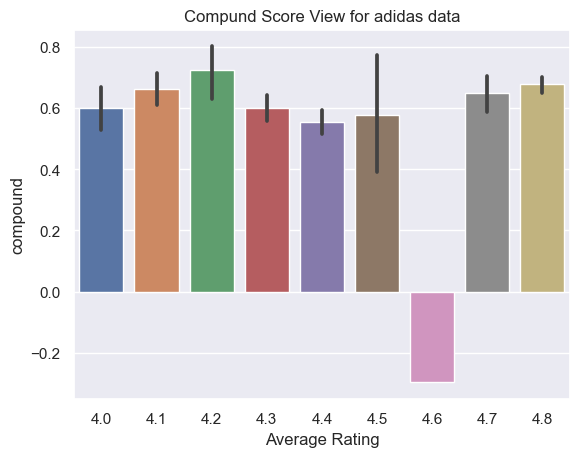

In [38]:
ax = sns.barplot(data=vaders, x='Average Rating', y='compound')
ax.set_title('Compund Score View for adidas data')
plt.show()

In [39]:
def show_compound_view(data, rating_column):
    #plot visualisation
    ax = sns.barplot(data=data, x='Average Rating', y=rating_column)
    ax.set_title(f'Varying  Average Rating By {rating_column}')
    plt.show()

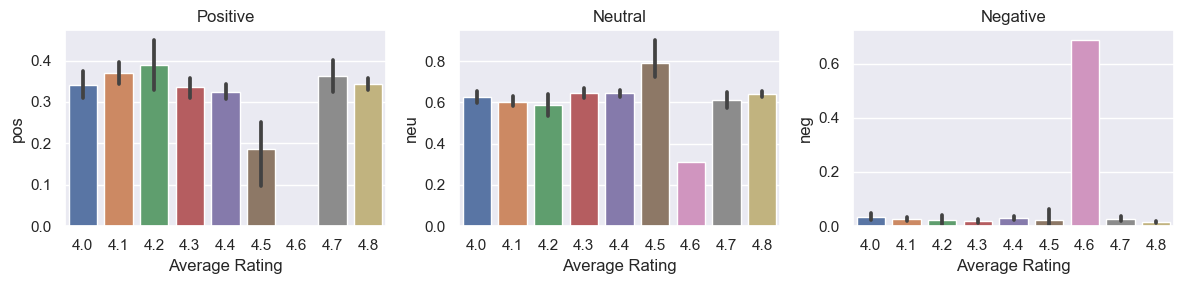

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Average Rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Average Rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Average Rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [41]:
def show_all_scores(data, pos, neu, neg):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    sns.barplot(data=data, x='Average Rating', y=pos, ax=axs[0])
    sns.barplot(data=data, x='Average Rating', y=neu, ax=axs[1])
    sns.barplot(data=data, x='Average Rating', y=neg, ax=axs[2])
    axs[0].set_title('Positive')
    axs[1].set_title('Neutral')
    axs[2].set_title('Negative')
    plt.tight_layout()
    plt.show()

***
# TextBlob
***

In [42]:
def get_textblob_scores(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    
    if polarity > 0:
        return polarity, 0, 0, 'positive', polarity
    elif polarity < 0:
        return 0, abs(polarity), 0, 'negative', polarity
    else:
        return 0, 0, 0, 'neutral', polarity

# Apply TextBlob sentiment analysis to the 'Review' column
df[['TextBlob_Pos', 'TextBlob_Neg', 'TextBlob_Neu', 'TextBlob_Polarity_Type', 'TextBlob_Polarity']] = df['Reviews'].apply(lambda x: pd.Series(get_textblob_scores(x)))


In [43]:
df.head()

,Title,Price,ColoursAvailable,ReviewTopic,Reviews,UserID,Date,VerifiedPurchaser,IncentivizedReview,ID,Average Rating,Vader_Pos,Vader_Neg,Vader_Neu,Vader_Polarity,TextBlob_Pos,TextBlob_Neg,TextBlob_Neu,TextBlob_Polarity_Type,TextBlob_Polarity
0,Samba OG Shoes,100,6,Nice quality shoes,They match practically with any outfit that I...,abdubs35,"September 13, 2023",False,False,1,4.8,0.000,0.000,1.000,0.0000,0.000000,0.0,0,neutral,0.000000
1,Samba OG Shoes,100,6,Nice shoes,"Very nice shoes , just not as green as the pic...",THEMAN,"September 13, 2023",False,True,2,4.8,0.256,0.000,0.744,0.4754,0.290000,0.0,0,positive,0.290000
2,Samba OG Shoes,100,6,Buy the shoes!,"Bang on trend, comfy and cool. Would recommend...",Huggsy,"September 12, 2023",True,True,3,4.8,0.348,0.000,0.652,0.5859,0.350000,0.0,0,positive,0.350000
3,Samba OG Shoes,100,6,ALL GOODS SOLID! WORTH THE PRICE!,THAT WAS DOPE! medyo mahaba lng ng very little...,TOYOTABOY,"September 12, 2023",False,False,4,4.8,0.077,0.142,0.781,-0.4997,0.210417,0.0,0,positive,0.210417
4,Samba OG Shoes,100,6,Never out of style,Love how light on your feet they are and comfo...,SangeBo,"September 12, 2023",False,False,5,4.8,0.283,0.000,0.717,0.8176,0.350000,0.0,0,positive,0.350000


***
># Visualising TextBlob Results
***

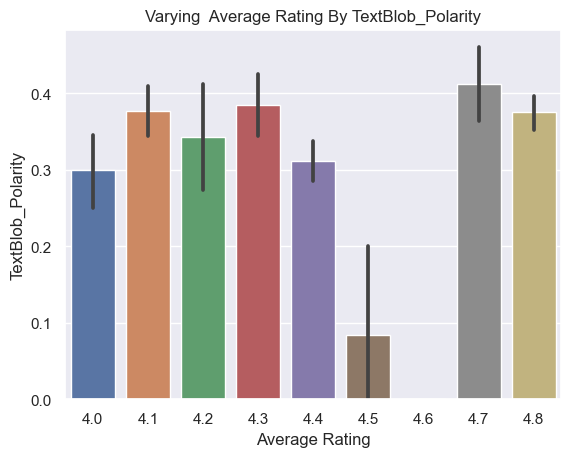

In [44]:
show_compound_view(df, "TextBlob_Polarity")

***
# SentiWordNet
***

In [45]:
#nltk.download('sentiwordnet')
#nltk.download('wordnet')

In [46]:
#nltk.download()
#nltk.download('omw-1.4')

In [47]:
# Define a mapping from NLTK POS tags to SentiWordNet POS tags
def get_sentiment(word, pos):
    if pos.startswith('J'):
        pos = 'a'
    elif pos.startswith('V'):
        pos = 'v'
    elif pos.startswith('N'):
        pos = 'n'
    elif pos.startswith('R'):
        pos = 'r'
    else:
        pos = None

    if pos:
        return list(swn.senti_synsets(word, pos))
    else:
        return []

def get_sentiwordnet_scores(text):
    pos_score = 0.0
    neg_score = 0.0
    neu_score = 0.0
    tokens_count = 0
    
    # Tokenize and tag parts of speech
    for word, pos in nltk.pos_tag(word_tokenize(text)):
        synsets = get_sentiment(word, pos)
        if synsets:
            synset = synsets[0]
            pos_score += synset.pos_score()
            neg_score += synset.neg_score()
            neu_score += synset.obj_score()
            tokens_count += 1
    
    if tokens_count == 0:
        return 0.0, 0.0, 0.0
    
    pos_score /= tokens_count
    neg_score /= tokens_count
    neu_score /= tokens_count
    
    return pos_score, neg_score, neu_score

# Apply SentiWordNet sentiment analysis to the 'Review' column
df[['SentiWordNet_Pos', 'SentiWordNet_Neg', 'SentiWordNet_Neu']] = df['Reviews'].apply(lambda x: pd.Series(get_sentiwordnet_scores(x)))

# Calculate the final sentiment polarity (positive - negative)
df['SentiWordNet_Polarity'] = df['SentiWordNet_Pos'] - df['SentiWordNet_Neg']


***
># Visualising SentiWordNet Results
***

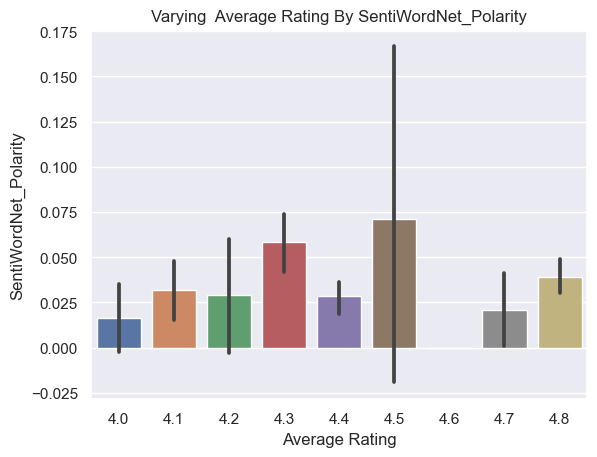

In [48]:
show_compound_view(df, 'SentiWordNet_Polarity')

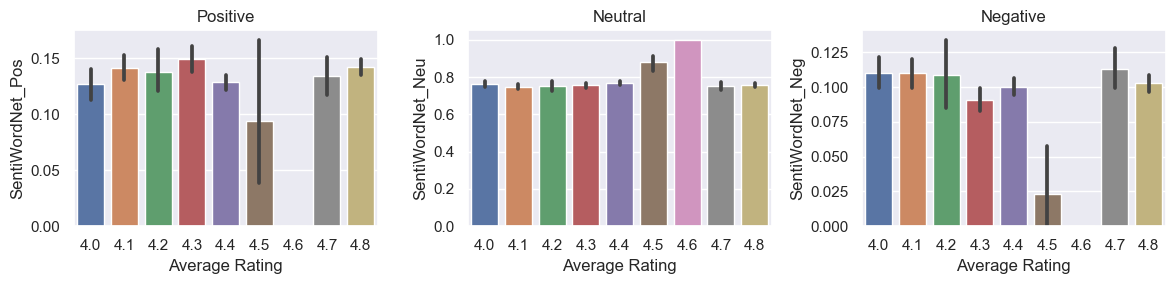

In [49]:
show_all_scores(df, 'SentiWordNet_Pos', 'SentiWordNet_Neu', 'SentiWordNet_Neg')

In [50]:
df.columns

Index(['Title', 'Price', 'ColoursAvailable', 'ReviewTopic', 'Reviews',
       'UserID', 'Date', 'VerifiedPurchaser', 'IncentivizedReview', 'ID',
       'Average Rating', 'Vader_Pos', 'Vader_Neg', 'Vader_Neu',
       'Vader_Polarity', 'TextBlob_Pos', 'TextBlob_Neg', 'TextBlob_Neu',
       'TextBlob_Polarity_Type', 'TextBlob_Polarity', 'SentiWordNet_Pos',
       'SentiWordNet_Neg', 'SentiWordNet_Neu', 'SentiWordNet_Polarity'],
      dtype='object')

***
# Combine and compare Results
***

In [51]:
df.head()

,Title,Price,ColoursAvailable,ReviewTopic,Reviews,UserID,Date,VerifiedPurchaser,IncentivizedReview,ID,...,Vader_Polarity,TextBlob_Pos,TextBlob_Neg,TextBlob_Neu,TextBlob_Polarity_Type,TextBlob_Polarity,SentiWordNet_Pos,SentiWordNet_Neg,SentiWordNet_Neu,SentiWordNet_Polarity
0,Samba OG Shoes,100,6,Nice quality shoes,They match practically with any outfit that I...,abdubs35,"September 13, 2023",False,False,1,...,0.0000,0.000000,0.0,0,neutral,0.000000,0.093750,0.062500,0.843750,0.031250
1,Samba OG Shoes,100,6,Nice shoes,"Very nice shoes , just not as green as the pic...",THEMAN,"September 13, 2023",False,True,2,...,0.4754,0.290000,0.0,0,positive,0.290000,0.140625,0.140625,0.718750,0.000000
2,Samba OG Shoes,100,6,Buy the shoes!,"Bang on trend, comfy and cool. Would recommend...",Huggsy,"September 12, 2023",True,True,3,...,0.5859,0.350000,0.0,0,positive,0.350000,0.187500,0.125000,0.687500,0.062500
3,Samba OG Shoes,100,6,ALL GOODS SOLID! WORTH THE PRICE!,THAT WAS DOPE! medyo mahaba lng ng very little...,TOYOTABOY,"September 12, 2023",False,False,4,...,-0.4997,0.210417,0.0,0,positive,0.210417,0.113095,0.101190,0.785714,0.011905
4,Samba OG Shoes,100,6,Never out of style,Love how light on your feet they are and comfo...,SangeBo,"September 12, 2023",False,False,5,...,0.8176,0.350000,0.0,0,positive,0.350000,0.125000,0.156250,0.718750,-0.031250


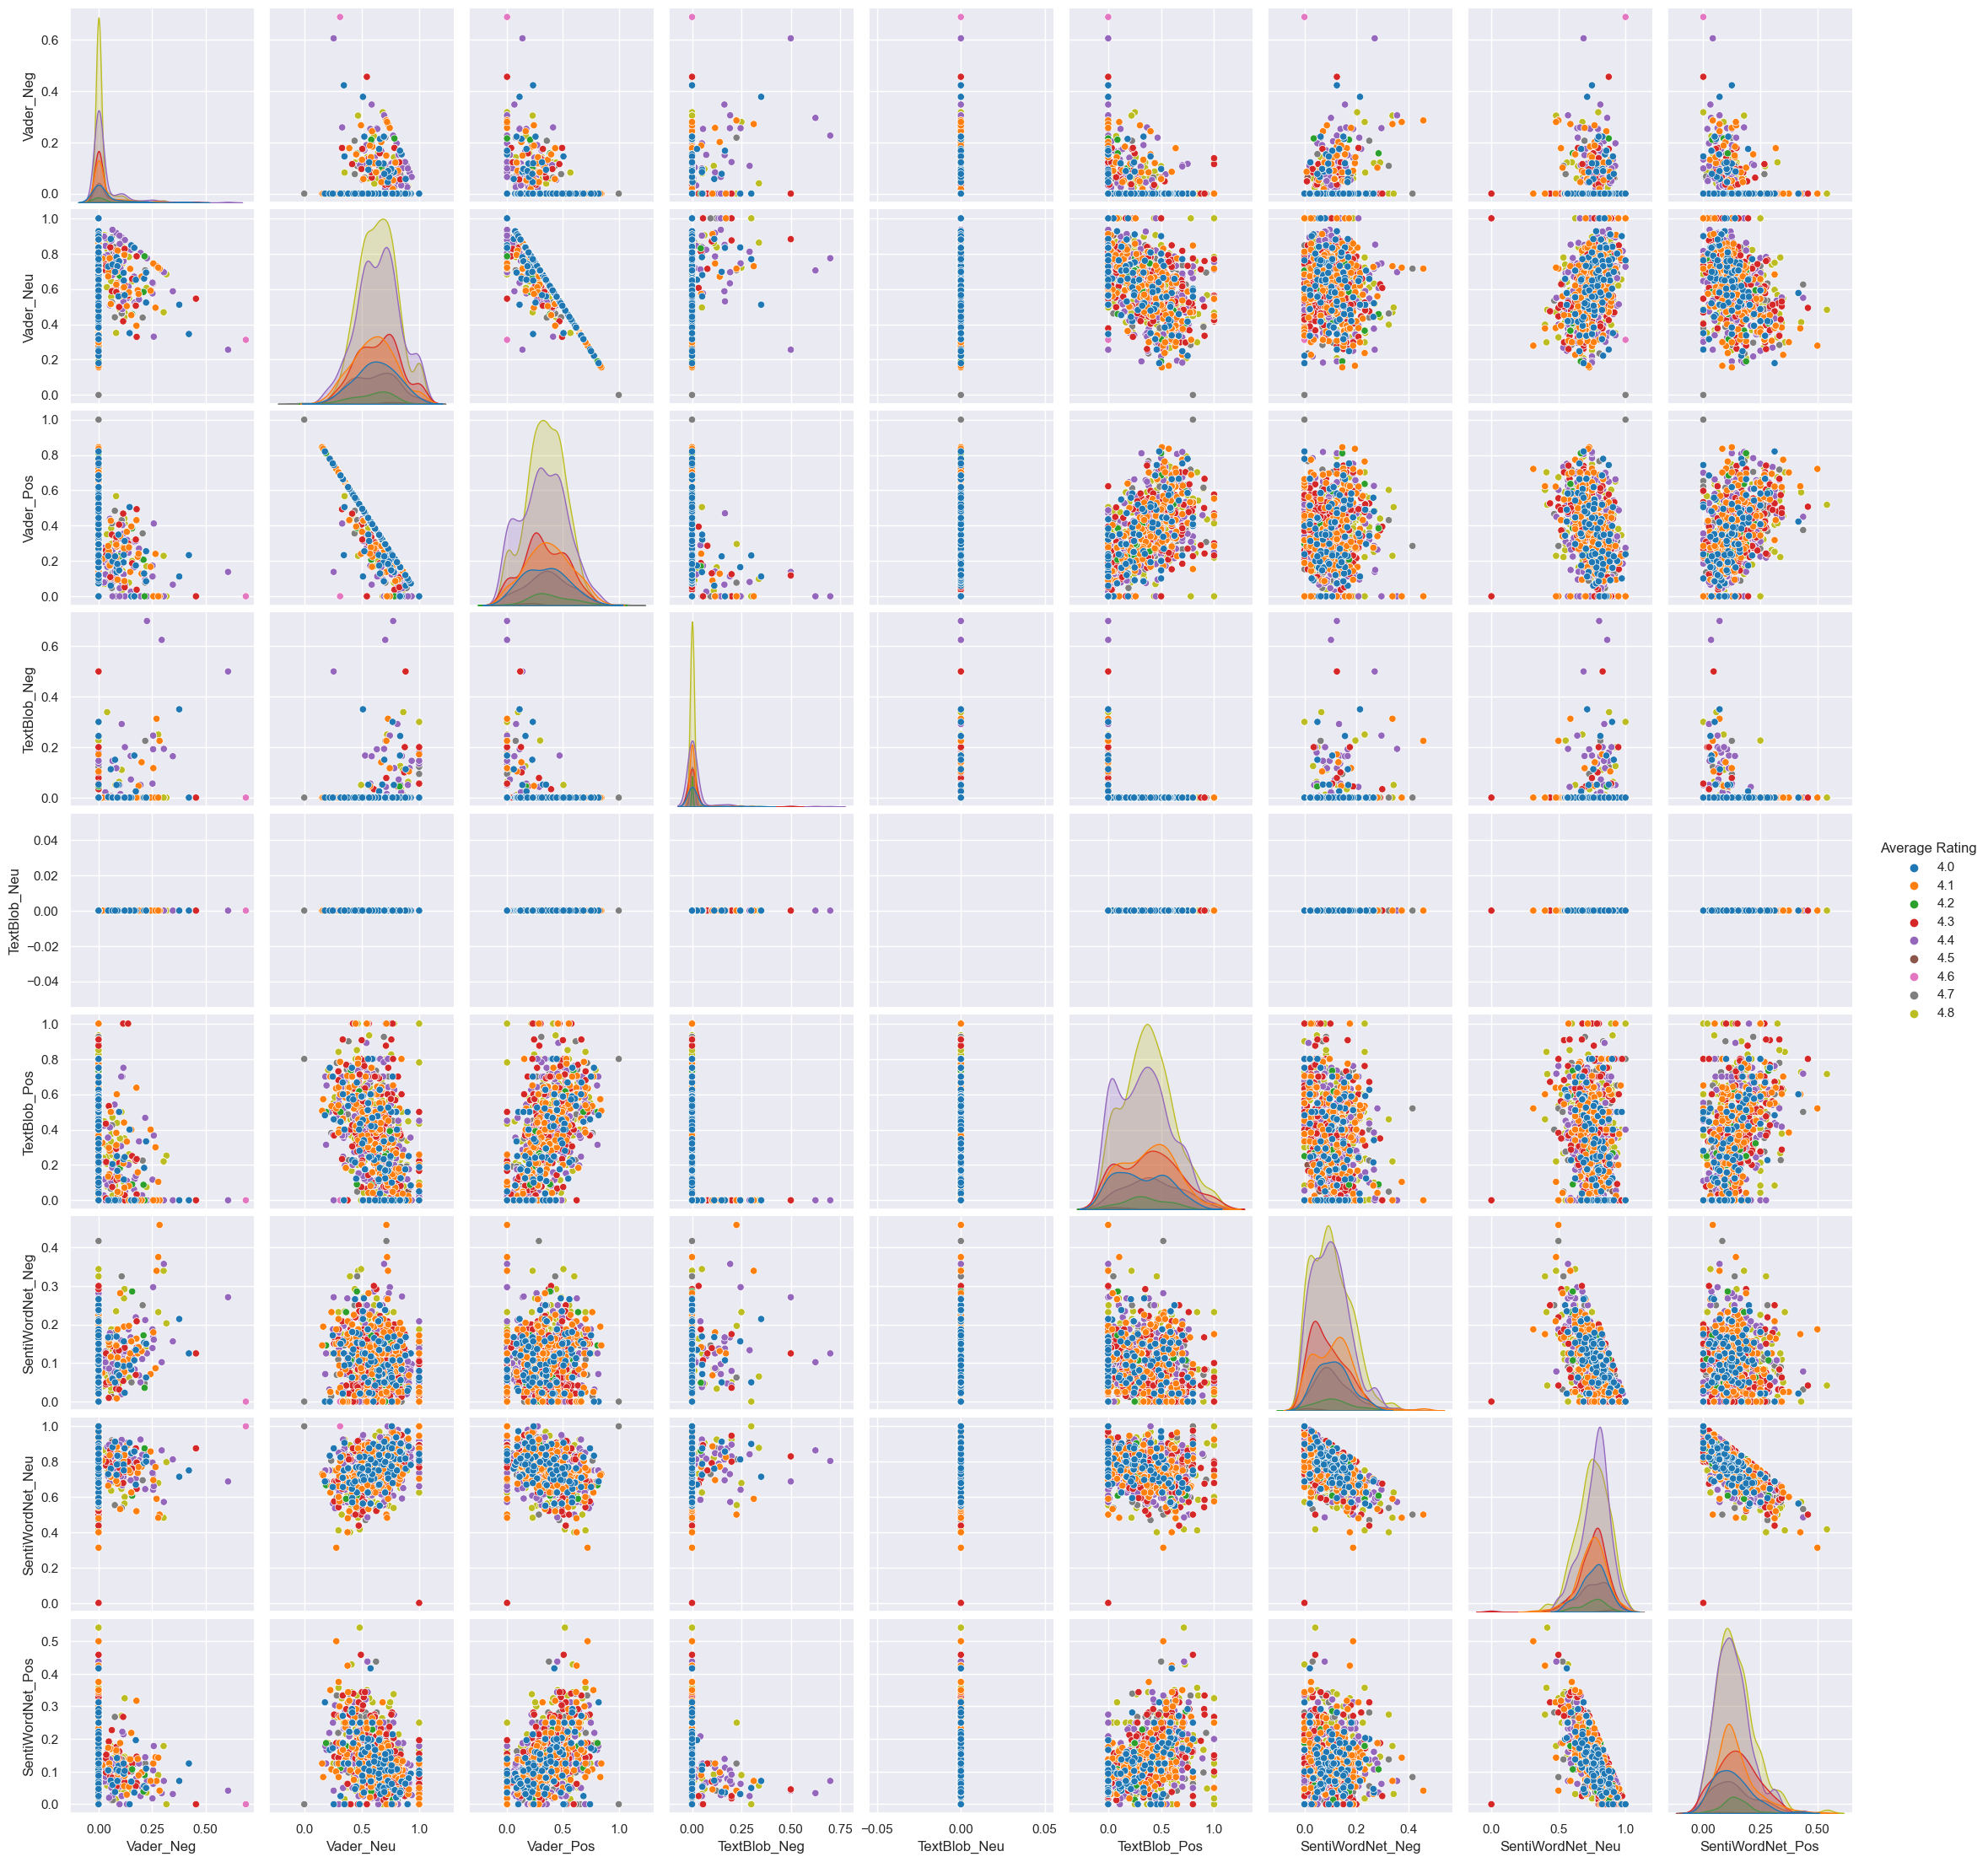

In [52]:
sns.pairplot(data=df,
             vars=['Vader_Neg', 'Vader_Neu', 'Vader_Pos',
                   'TextBlob_Neg', 'TextBlob_Neu', 'TextBlob_Pos',
                   'SentiWordNet_Neg', 'SentiWordNet_Neu', 'SentiWordNet_Pos'],
            hue='Average Rating', 
            palette='tab10')
plt.show()


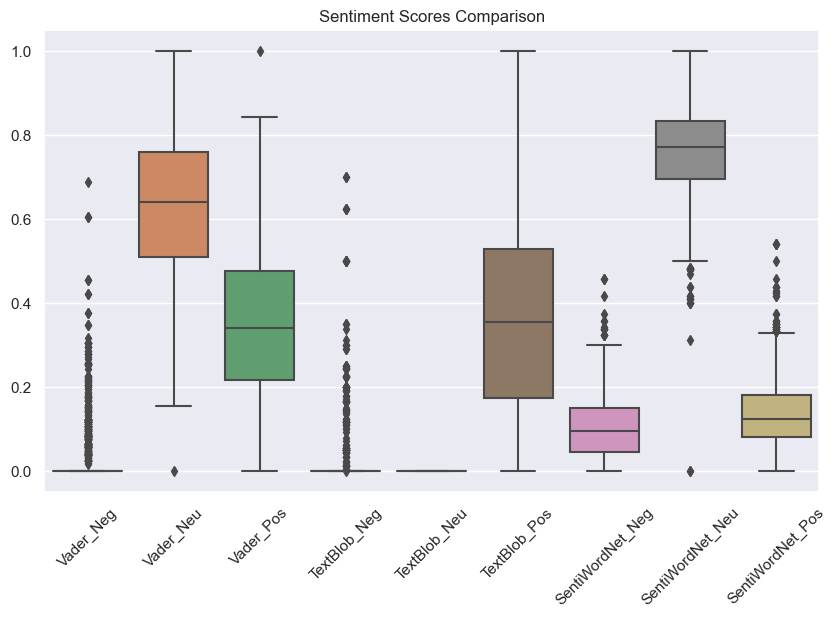

In [53]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Vader_Neg', 'Vader_Neu', 'Vader_Pos',
                   'TextBlob_Neg', 'TextBlob_Neu', 'TextBlob_Pos',
                   'SentiWordNet_Neg', 'SentiWordNet_Neu', 'SentiWordNet_Pos']])
plt.title('Sentiment Scores Comparison')
plt.xticks(rotation=45)
plt.show()

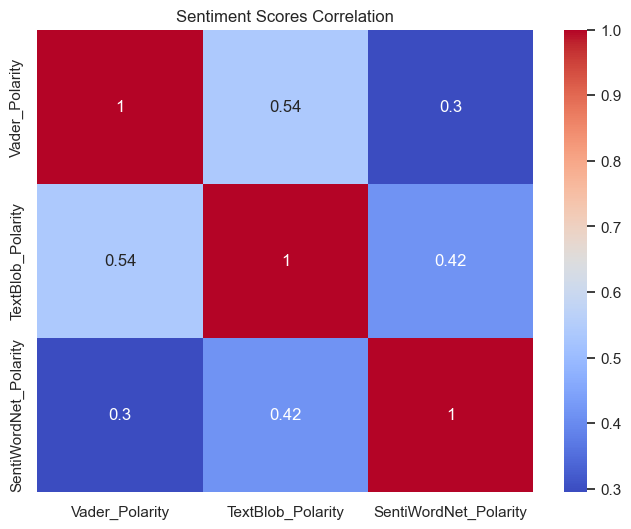

In [54]:
correlation = df[['Vader_Polarity', 'TextBlob_Polarity', 'SentiWordNet_Polarity']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Sentiment Scores Correlation')
plt.show()

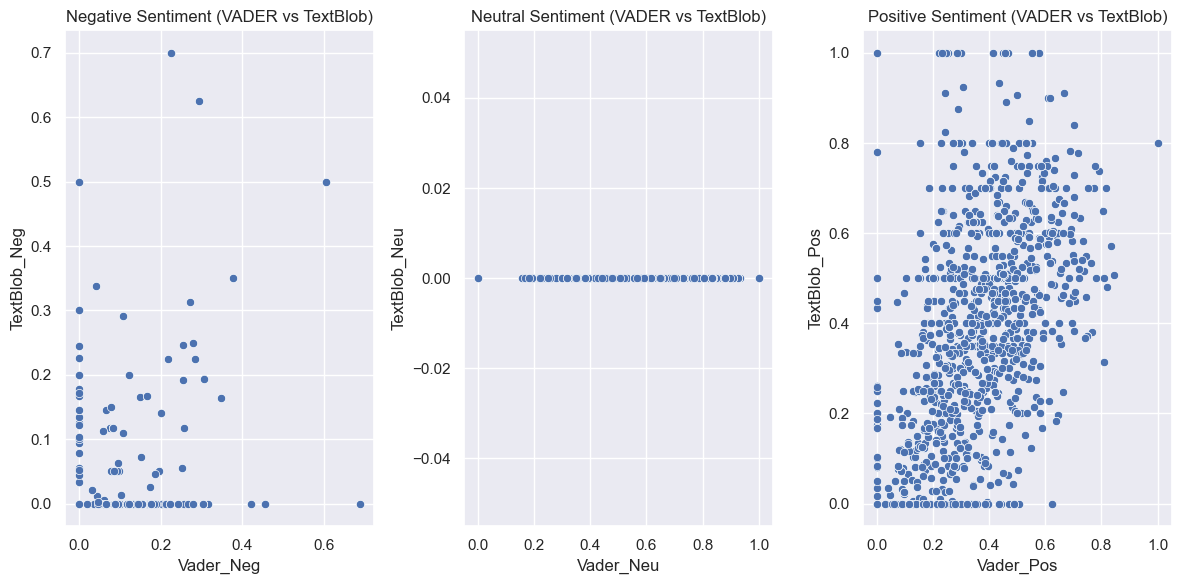

In [55]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
sns.scatterplot(x='Vader_Neg', y='TextBlob_Neg', data=df)
plt.title('Negative Sentiment (VADER vs TextBlob)')
plt.subplot(132)
sns.scatterplot(x='Vader_Neu', y='TextBlob_Neu', data=df)
plt.title('Neutral Sentiment (VADER vs TextBlob)')
plt.subplot(133)
sns.scatterplot(x='Vader_Pos', y='TextBlob_Pos', data=df)
plt.title('Positive Sentiment (VADER vs TextBlob)')
plt.tight_layout()
plt.show()

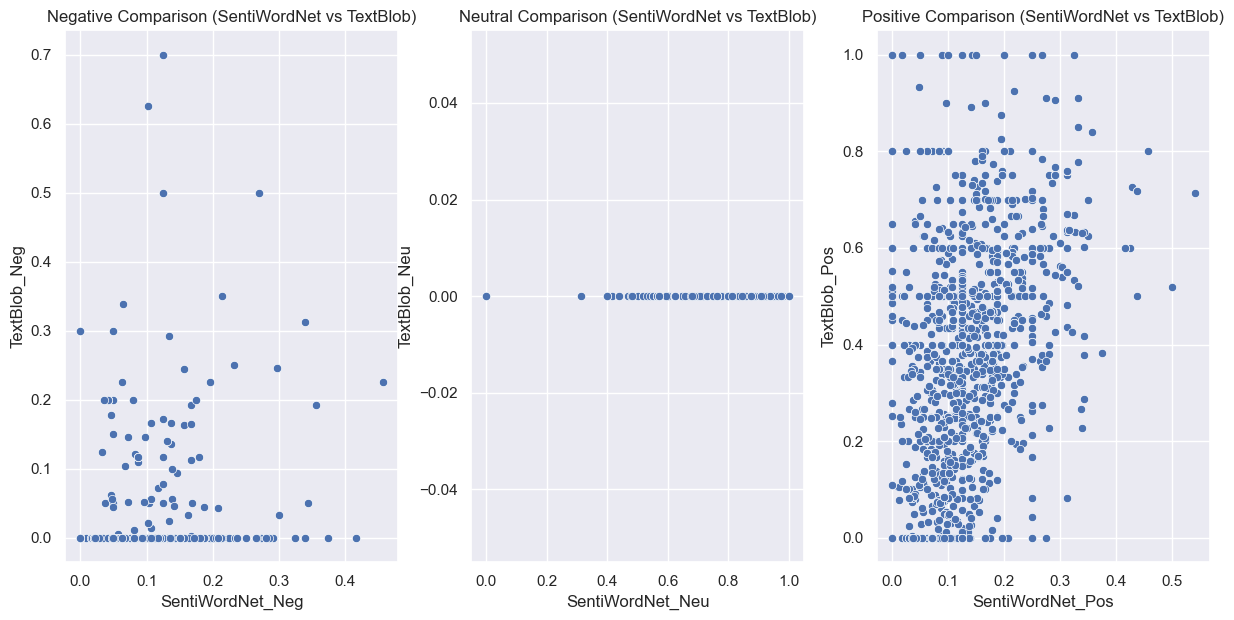

In [56]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
sns.scatterplot(x='SentiWordNet_Neg', y='TextBlob_Neg', data=df)
plt.title('Negative Comparison (SentiWordNet vs TextBlob)')
plt.subplot(132)
sns.scatterplot(x='SentiWordNet_Neu', y='TextBlob_Neu', data=df)
plt.title('Neutral Comparison (SentiWordNet vs TextBlob)')
plt.subplot(133)
sns.scatterplot(x='SentiWordNet_Pos', y='TextBlob_Pos', data=df)
plt.title('Positive Comparison (SentiWordNet vs TextBlob)')
plt.tight_layout(pad=0)
plt.show()

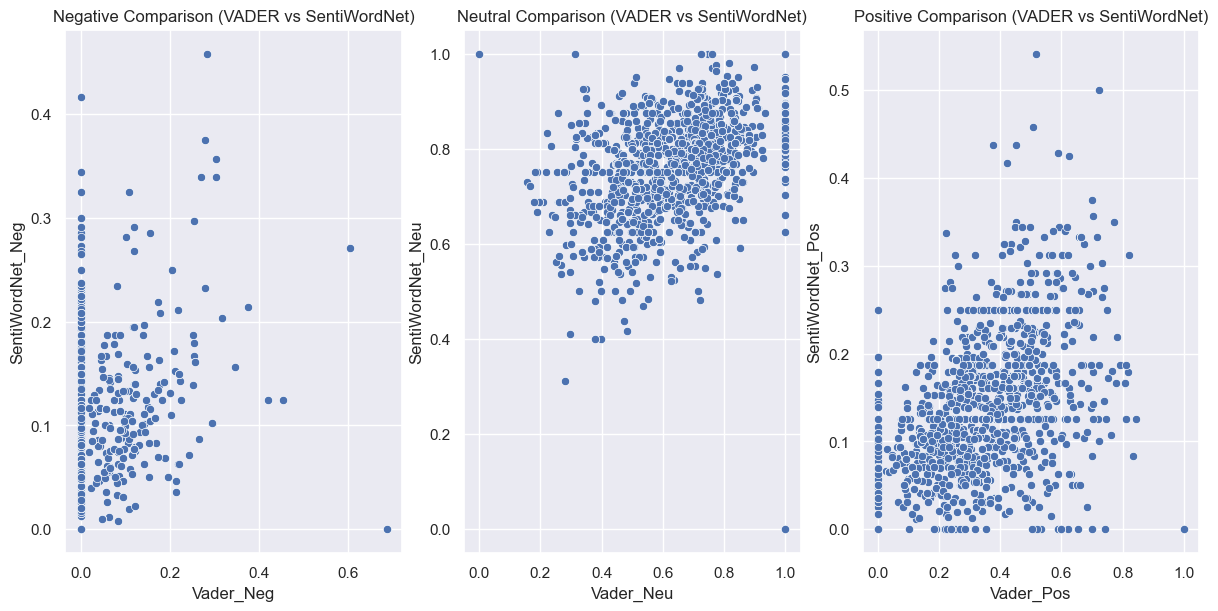

In [57]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
sns.scatterplot(x='Vader_Neg', y='SentiWordNet_Neg', data=df)
plt.title('Negative Comparison (VADER vs SentiWordNet)')
plt.subplot(132)
sns.scatterplot(x='Vader_Neu', y='SentiWordNet_Neu', data=df)
plt.title('Neutral Comparison (VADER vs SentiWordNet)')
plt.subplot(133)
sns.scatterplot(x='Vader_Pos', y='SentiWordNet_Pos', data=df)
plt.title('Positive Comparison (VADER vs SentiWordNet)')
plt.tight_layout(pad=0.25)
plt.show()

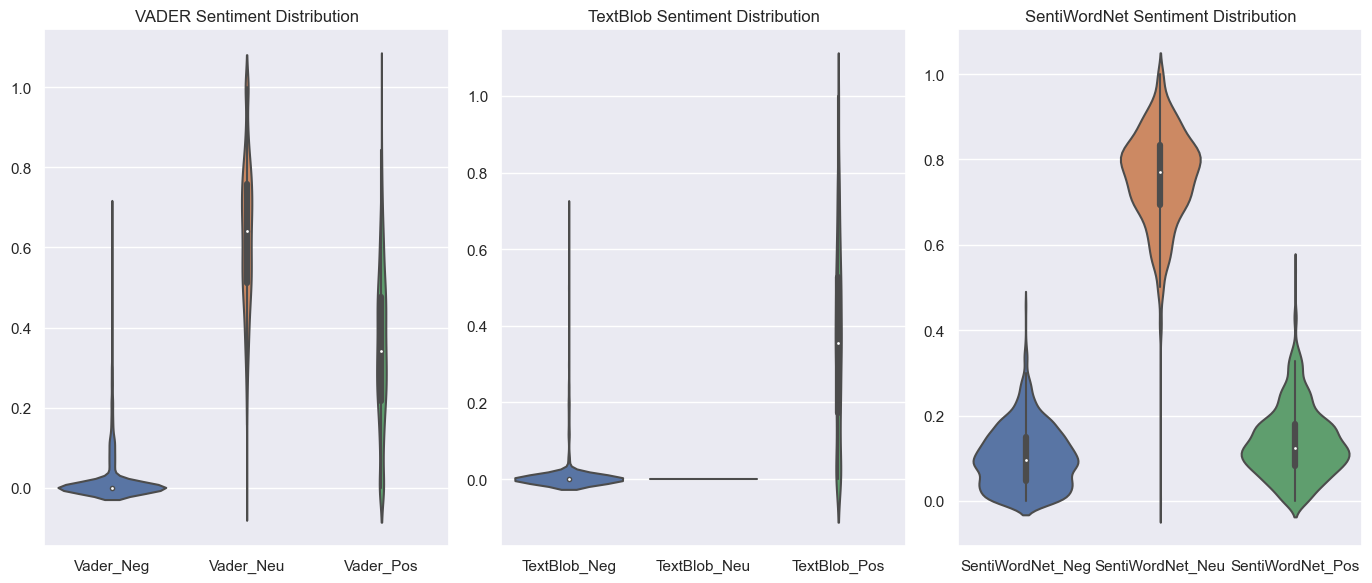

In [58]:
plt.figure(figsize=(14, 6))
plt.subplot(131)
sns.violinplot(data=df[['Vader_Neg', 'Vader_Neu', 'Vader_Pos']])
plt.title('VADER Sentiment Distribution')
plt.subplot(132)
sns.violinplot(data=df[['TextBlob_Neg', 'TextBlob_Neu', 'TextBlob_Pos']])
plt.title('TextBlob Sentiment Distribution')
plt.subplot(133)
sns.violinplot(data=df[['SentiWordNet_Neg', 'SentiWordNet_Neu', 'SentiWordNet_Pos']])
plt.title('SentiWordNet Sentiment Distribution')
plt.tight_layout()
plt.show()

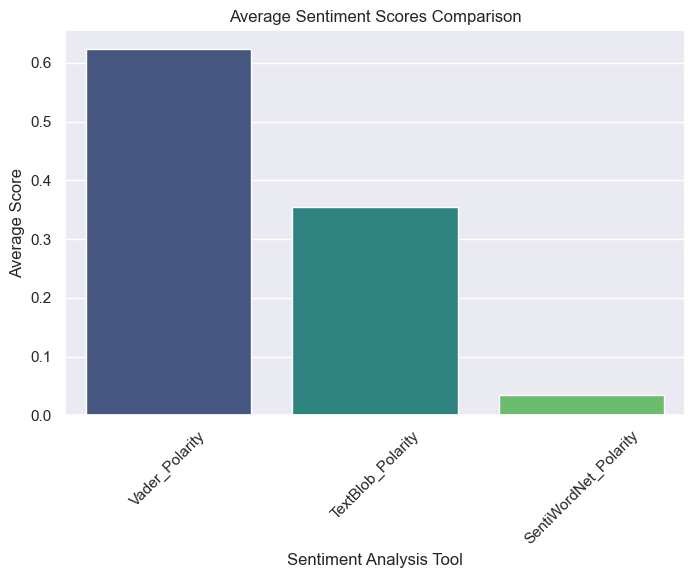

In [59]:
average_scores = df[['Vader_Polarity', 'TextBlob_Polarity', 'SentiWordNet_Polarity']].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=average_scores.index, y=average_scores.values, palette='viridis')
plt.title('Average Sentiment Scores Comparison')
plt.xlabel('Sentiment Analysis Tool')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.show()

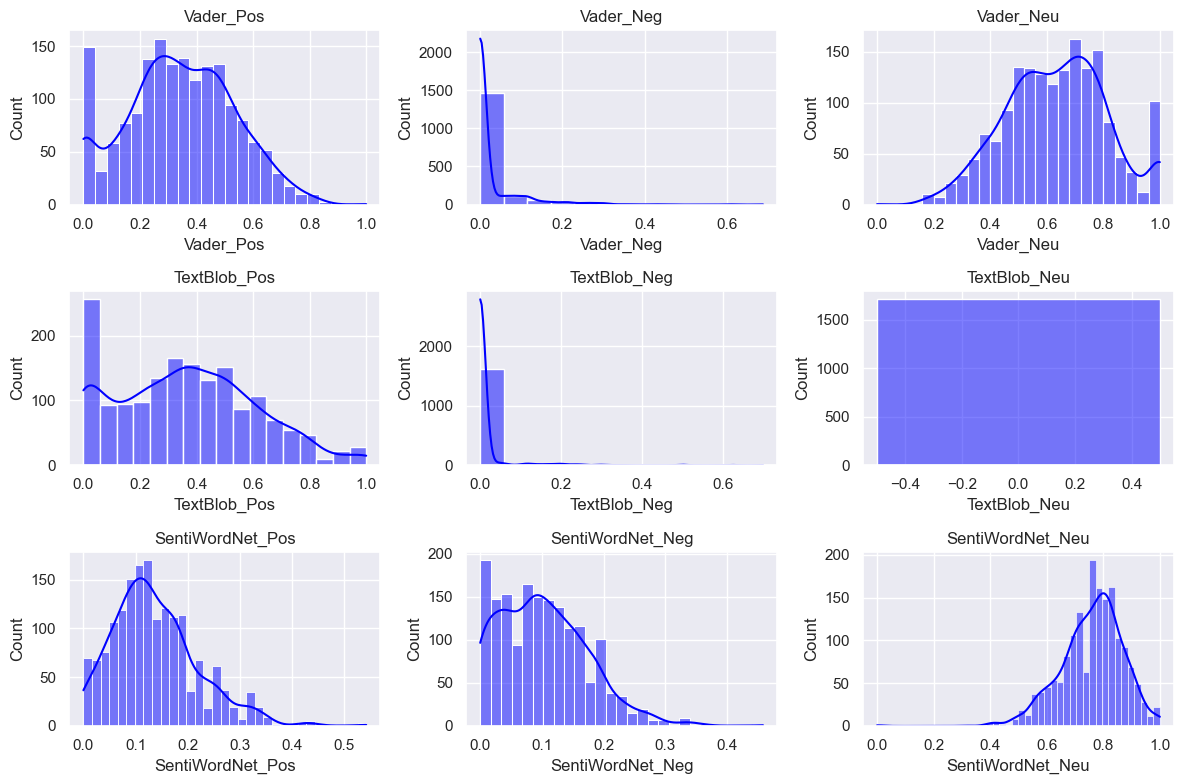

In [60]:
sentiment_columns = ['Vader_Pos', 'Vader_Neg', 'Vader_Neu',
                     'TextBlob_Pos', 'TextBlob_Neg', 'TextBlob_Neu',
                     'SentiWordNet_Pos', 'SentiWordNet_Neg', 'SentiWordNet_Neu']

plt.figure(figsize=(12, 8))
for i, col in enumerate(sentiment_columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(col)
    plt.tight_layout()

plt.show()


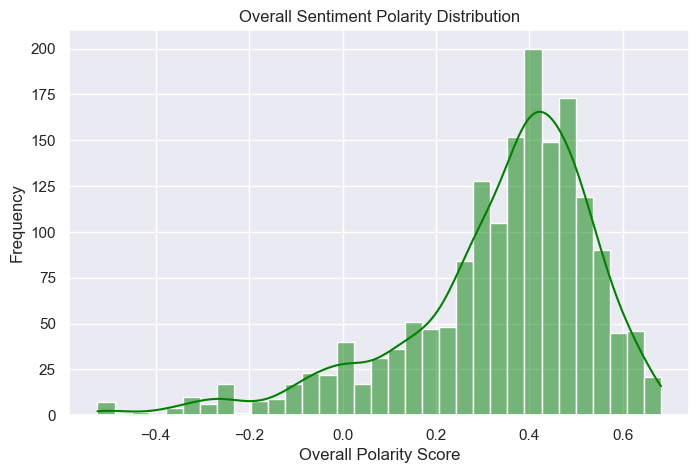

In [61]:
plt.figure(figsize=(8, 5))
sns.histplot(df[['Vader_Polarity', 'TextBlob_Polarity', 'SentiWordNet_Polarity']].mean(axis=1), kde=True, color='green')
plt.title('Overall Sentiment Polarity Distribution')
plt.xlabel('Overall Polarity Score')
plt.ylabel('Frequency')
plt.show()


***
# Conclusion
***